# Using `nnde` (`delta`) to solve `lagaris01`

## Introduction

The purpose of this notebook is to provide a a reference solution of the `lagaris01` ODE problem using `nnde` code and the `delta` training algorithm, with a larger learning rate.

## The `lagaris01` ODE problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import platform
import sys

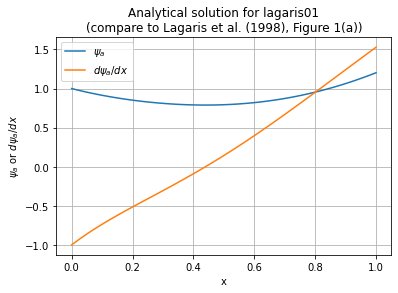

In [2]:
# Import the problem definition.
eq_name = "lagaris01"
eq_module = 'nnde.differentialequation.examples.lagaris_01'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivative.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
Ya = np.zeros(na)
dYa_dx = np.zeros(na)
for i in range(na):
    Ya[i] = eq.Ya(xa[i])
    dYa_dx[i] = eq.dYa_dx(xa[i])

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Solving `lagaris01` using the `nnde` package

In [3]:
# Hyperparameters for the problem and network.

# Number of training points and range.
nt = 11
xt_range = (0, 1)

# Number of hidden nodes.
H = 10

# Training algorithm.
training_algorithm = 'delta'

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.011

# Starting ranges for network parameters.
w0_range = (-1, 1)
u0_range = (-1, 1)
v0_range = (-1, 1)

# Random number generator seed.
random_seed = 0

In [4]:
# Load the nnde packages needed for this problem.
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
from nnde.differentialequation.ode.ode1ivp import ODE1IVP

# Print the system information.
print(datetime.datetime.now())
print("Host name: %s" % platform.node())
print("OS: %s" % platform.platform())
print("uname:", platform.uname())
print("Python version: %s" % sys.version)
print("Python build:", platform.python_build())
print("Python compiler: %s" % platform.python_compiler())
print("Python implementation: %s" % platform.python_implementation())

# Create the training data.
(xmin, xmax) = xt_range
xt = np.linspace(xmin, xmax, nt)

# Create the ODE object for the problem.
ode = ODE1IVP(eq_module)

# Create the network.
net = NNODE1IVP(ode, nhid=H)

# Specify training options.
opts = {}
opts["eta"] = learning_rate
opts["maxepochs"] = n_epochs  # Number of training epochs
opts["bmin"] = u0_range[0]
opts["bmax"] = u0_range[1]
opts["vmin"] = v0_range[0]
opts["vmax"] = v0_range[1]
opts["wmin"] = w0_range[0]
opts["wmax"] = w0_range[1]

# Train the network.
np.random.seed(random_seed)
print("\nStaring training.")
print(datetime.datetime.now())
%timeit -n 1 -r 1 net.train(xt, trainalg=training_algorithm, opts=opts)
print(datetime.datetime.now())

2021-07-05 10:58:43.464942
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.5.0', version='Darwin Kernel Version 20.5.0: Sat May  8 05:10:33 PDT 2021; root:xnu-7195.121.3~9/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
Python build: ('default', 'May 19 2021 11:01:55')
Python compiler: Clang 10.0.0 
Python implementation: CPython

Staring training.
2021-07-05 10:58:43.477671
361 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2021-07-05 10:58:43.840750


In [5]:
# Compute the trained solution and derivative at the training points.
Yt = net.run(xt)
dYt_dx = net.run_derivative(xt)

# Compute the analytical solution and derivative at the training points.
Yat = [eq.Ya(x) for x in xt]
dYat_dx = [eq.dYa_dx(x) for x in xt]

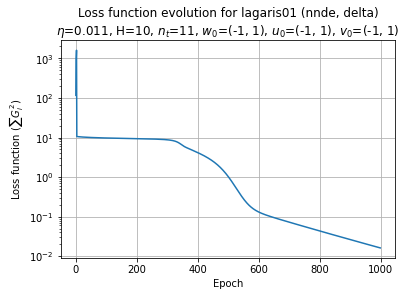

In [6]:
# Plot the loss function history.
plt.semilogy(net.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'nnde', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

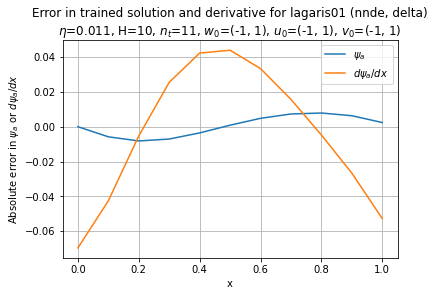

In [7]:
# Plot the errors in the trained solution and derivative.
plt.plot(xt, Yt - Yat, label="$\psi_a$")
plt.plot(xt, dYt_dx - dYat_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'nnde', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

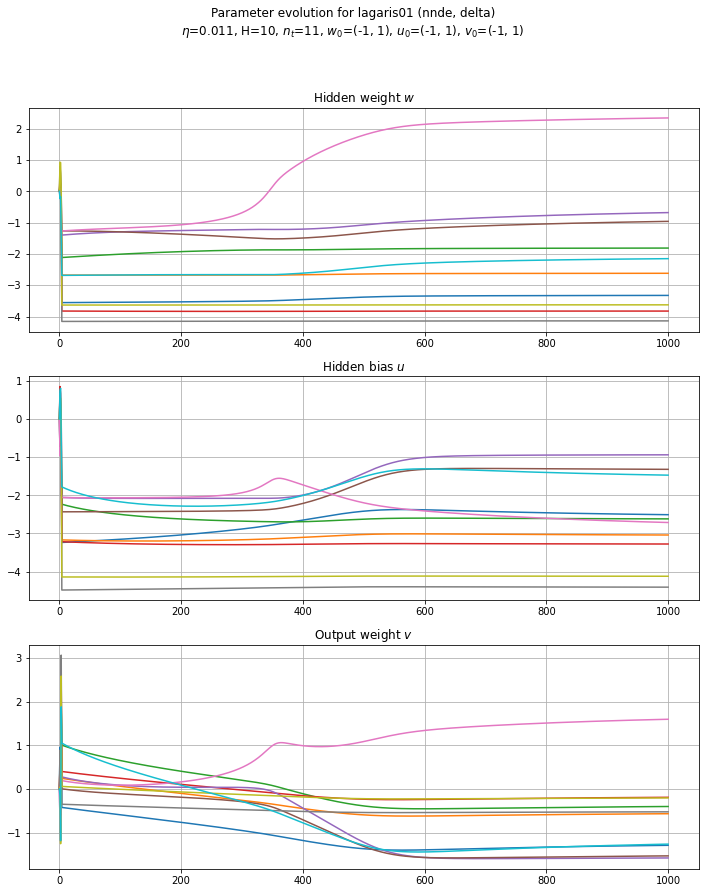

In [8]:
# Plot the parameter histories.
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(net.phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(net.phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(net.phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'nnde', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()